<a href="https://colab.research.google.com/github/gabriellycristine1/PROJETO-MELANOMA/blob/main/PROJETO_FINALIZADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando Bibliotecas

In [ ]:
!pip install -U efficientnet
import sys
import os
from os.path import join
import numpy as np 
import matplotlib.pyplot as plt
import efficientnet.keras as efn 
import tensorflow as tf
!pip install --user tensorflow-addons==0.8.3
!pip install --user tensorflow==2.2.0-rc3a
from keras.preprocessing.image import load_img, img_to_array
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense , Dropout , Flatten , MaxPooling2D , BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import zipfile
from google.colab.patches import cv2_imshow
from google.colab import drive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0-rc3a (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.0+zzzcolab20220506153740, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.4+zzzcolab20220516125453, 2.6.5, 2.6.5+zzzcolab20220523104206, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.0+zzzcolab20220506150900, 2.7.1, 2.

conectando o drive ao google colab para importação do arquivo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


abrindo o arquivo zipado

In [ ]:
path = '/content/drive/MyDrive/MELANOMA_FINAL.zip'
zip_object = zipfile.ZipFile(file = path, mode='r')
zip_object.extractall('./')
zip_object.close()

copiando o caminho do diretorio

In [ ]:
PATH = "/content/DermMel"

verificando o nome das pastas

In [ ]:
print('Total Directories')
display(os.listdir(PATH))

Total Directories


['train_sep', 'valid', 'test']

verificação de quantas imagens temos para treino, teste e validação 

In [ ]:
PATHtrain = "/content/DermMel/train_sep"
print(len(os.listdir(PATHtrain)), "PASTAS DE TREINO")
drs = os.listdir(PATHtrain)
im_len = 0
for label in sorted(drs):
    print(label,len(os.listdir('/content/DermMel/train_sep/Melanoma')))
    im_len = im_len + len(os.listdir('/content/DermMel/train_sep/NotMelanoma'))

print("TOTAL DE FOTOS PARA TREINO", im_len)
print("_"*50)

PATHvalid = '/content/DermMel/valid'
print(len(os.listdir(PATHvalid)), "PASTAS DE VALIDAÇÃO")
drs = os.listdir(PATHvalid)
im_len = 0
for label in sorted(drs):
    print(label,len(os.listdir('/content/DermMel/valid/Melanoma')))
    im_len = im_len + len(os.listdir('/content/DermMel/valid/NotMelanoma'))

print("TOTAL DE FOTOS PARA VALIDAÇÃO", im_len)
print("_"*50)

PATHtest ='/content/DermMel/test'
print(len(os.listdir(PATHtest)), "PASTAS DE TESTE")
drs = os.listdir(PATHtest)
im_len = 0

for label in sorted(drs):
    print(label,len(os.listdir('/content/DermMel/test/Melanoma')))
    im_len = im_len + len(os.listdir('/content/DermMel/test/NotMelanoma'))

print("TOTAL DE FOTOS PARA TESTE", im_len)
print("_"*50)

2 PASTAS DE TREINO
Melanoma 5341
NotMelanoma 5341
TOTAL DE FOTOS PARA TREINO 10682
__________________________________________________
2 PASTAS DE VALIDAÇÃO
Melanoma 1781
NotMelanoma 1781
TOTAL DE FOTOS PARA VALIDAÇÃO 3562
__________________________________________________
2 PASTAS DE TESTE
Melanoma 1781
NotMelanoma 1781
TOTAL DE FOTOS PARA TESTE 3560
__________________________________________________


In [ ]:
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

função criada para converter as imagens em escala de cinza

In [ ]:
def dados_imagem():
  caminhos = [os.path.join('/content/DermMel/train_sep/Melanoma', f) for f in os.listdir('/content/DermMel/train_sep/Melanoma')]
  mela = []
  for caminho in caminhos:
    imagem = cv2.imread(caminho)
    imagem = Image.open(caminho).convert('L')
    imagem_np = np.array(imagem, 'uint8')
    val, thresh = cv2.threshold(imagem_np, 155, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    
    mela.append(thresh)
  return mela

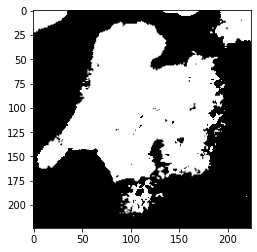

In [ ]:
mela = dados_imagem()

In [ ]:
from efficientnet.tfkeras import EfficientNetB7
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import MaxPool2D
from keras.regularizers import l2
from google.colab.patches import cv2
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

O EfficientNetB0 é usado porque é um modelo confiável para uma precisão relativamente boa e porque é rápido de treinar devido ao baixo número de parâmetros.

In [ ]:
eff = EfficientNetB7(input_shape=(100,100,3) , include_top=False , weights='imagenet')

model = Sequential()
model.add(eff)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128 , activation='relu' , kernel_regularizer=regularizers.l2(0.01) ))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid')) 

258449408/258434480 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functional  (None, 4, 4, 2560)       64097680  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 40960)             0         
                                                                 
 dropout (Dropout)           (None, 40960)             0         
                                                                 
 dense (Dense)               (None, 128)               5243008   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

usando o "imageDataGenerator" para gerar novas imagens para treino e definindo as classes em 0 e 1

In [ ]:
train_dir = PATHtrain
validation_dir = PATHvalid
test_dir = PATHtest
batch_size = 50
target_size=(100, 100)

#train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,target_size=target_size,batch_size=batch_size)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,target_size=target_size,batch_size=batch_size)
test_generator = test_datagen.flow_from_directory(
    test_dir,target_size=target_size,batch_size=batch_size)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


verificando as classes

In [ ]:
print(train_generator.class_indices)

{'Melanoma': 0, 'NotMelanoma': 1}


definindo os parametros que vao ser usados dentro de callback

In [ ]:
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        patience = 8, 
                                        restore_best_weights = True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'] )  

In [ ]:
checkpoint = ModelCheckpoint('chest_orientation_model.hdf5', 
                             monitor='val_loss', 
                             verbose=1, mode='min', 
                             save_best_only=True)


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [ ]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001)

treianando e validando nosso modelo

In [ ]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              steps_per_epoch = 10682 // batch_size,
                              validation_data = validation_generator,
                              validation_steps = 3562 // batch_size,
                              callbacks=[earlystopping,checkpoint,reduceLROnPlat])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
213/213 [==============================] - ETA: 0s - loss: 1.0808 - accuracy: 0.8757
Epoch 1: val_loss improved from inf to 1.33287, saving model to chest_orientation_model.hdf5
213/213 [==============================] - 223s 841ms/step - loss: 1.0808 - accuracy: 0.8757 - val_loss: 1.3329 - val_accuracy: 0.5014 - lr: 0.0010
Epoch 2/30
213/213 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.9243
Epoch 2: val_loss improved from 1.33287 to 0.38237, saving model to chest_orientation_model.hdf5
213/213 [==============================] - 166s 780ms/step - loss: 0.2986 - accuracy: 0.9243 - val_loss: 0.3824 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 3/30
213/213 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.9331
Epoch 3: val_loss improved from 0.38237 to 0.32397, saving model to chest_orientation_model.hdf5
213/213 [==============================] - 166s 779ms/step - loss: 0.3026 - accuracy: 0.9331 - val_loss: 0.3240 - val_accuracy: 0

criando graficos

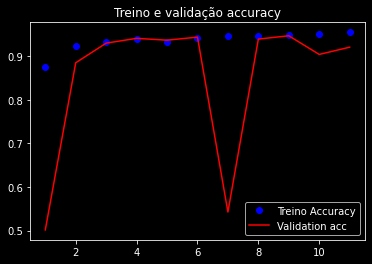

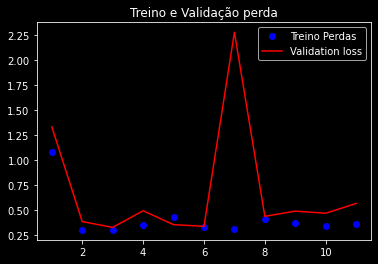

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.style.use('dark_background')
plt.plot(epochs, acc, 'bo', label='Treino Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Treino e validação accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Treino Perdas')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Treino e Validação perda')
plt.legend()
plt.show()

salvando modelo

In [ ]:
#!pip install simpletransformers

In [ ]:

y=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
true_labels=np.argmax(y, axis=-1)

prediction= model.predict(test_generator, verbose=2)
prediction=np.argmax(prediction, axis=-1)

72/72 - 27s - 27s/epoch - 375ms/step


estartisticas do nosso modelo

In [ ]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(true_labels,prediction) 
print('Accuracy: %.3f' % acc)
from sklearn.metrics import precision_score
precision = precision_score(true_labels,prediction,labels=[1,2], average='micro')
print('Precisao: %.3f' % precision)
from sklearn.metrics import recall_score
recall = recall_score(true_labels,prediction, average='binary')


Accuracy: 0.918
Precisao: 0.912


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=true_labels, y_pred=prediction)
cm

array([[1621,  160],
       [ 131, 1649]])

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

In [ ]:
from keras import models

In [ ]:
path = '/content/drive/MyDrive/chest_orientation_model.zip'
zip_object = zipfile.ZipFile(file = path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
model = models.load_model('/content/chest_orientation_model.hdf5')

In [ ]:
import cv2
import numpy as np
from skimage.transform import resize
from keras.preprocessing import image
from PIL import Image

In [ ]:
path = '/content/drive/MyDrive/melanoma_cancer_dataset-20220802T172035Z-001.zip'
zip_object = zipfile.ZipFile(file = path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
img = Image.open('/content/melanoma_cancer_dataset-20220802T172035Z-001/melanoma_cancer_dataset/test/benign/melanoma_9628.jpg')
img_np = np.array(img, 'uint8')
img_np = np.expand_dims(img_np,axis=0)

In [ ]:
img_np.shape

(1, 100, 100, 3)

In [ ]:
reconhecedor = model.predict(img_np.reshape(1,100,100,3))
print(reconhecedor)

[[0. 1.]]


In [ ]:
import torch

In [ ]:
prev = torch.tensor(reconhecedor)
x_rand = torch.rand_like(prev, dtype=torch.float)
print(x_rand)


tensor([[0.3025, 0.5224]])


In [ ]:
x_rand1 = np.array(x_rand)
x_rand1

array([[0.3025298, 0.522416 ]], dtype=float32)

1


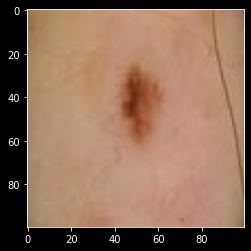

In [ ]:
pred_class = np.argmax(x_rand1)
print(pred_class)
plt.imshow(img)